In [1]:
import os
import tarfile
import re
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import zipfile

# Raw Radar Data

In [2]:
path_ds = '/nobackup/users/schreurs/project_GAN/dataset'

In [3]:
ls /nobackup/users/schreurs/project_GAN/dataset | head -5

RAD25_OPER_R___TARRRE__L2__201812170755_201812180800_0001/
RAD25_OPER_R___TARRRE__L2__201812170755_201812180800_0001.tar
RAD25_OPER_R___TARRRE__L2__201812180755_201812190800_0001/
RAD25_OPER_R___TARRRE__L2__201812180755_201812190800_0001.tar
RAD25_OPER_R___TARRRE__L2__201812190755_201812200800_0001/
ls: write error


In [4]:
files = [f for f in os.listdir(path_ds) if os.path.isfile(os.path.join(path_ds, f))]
print("Number of days in dataset = ", len(files))

Number of days in dataset =  772


In [5]:
files[0]

'RAD25_OPER_R___TARRRE__L2__20190826T080500_20190827T080000_0001.tar'

## Unpack the tar files
The download dataset consists of 772 days each packed in a tar file. With the code below the tar files are unpacked into folders with the same name

In [5]:
# Testing path
tar_path = path_ds + '/' + files[0]
print("tar path: ", tar_path)
unpack_folder = tar_path.replace('.tar','')
print("unpack in folder: ", unpack_folder)

tar path:  /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190826T080500_20190827T080000_0001.tar
unpack in folder:  /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190826T080500_20190827T080000_0001


In [16]:
for file in files:
    tar_path = path_ds + '/' + file
    unpack_folder = tar_path.replace('.tar', '')
    
    tar_file = tarfile.open(tar_path)
    tar_file.extractall(unpack_folder) 
    tar_file.close()

## Open folders

Opening files in the create folders:

In [6]:
folders = [f for f in os.listdir(path_ds) if os.path.isdir(os.path.join(path_ds, f))]

In [7]:
radar_dir = path_ds + '/' + folders[0]
radar_dir

'/nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190316T080500_20190317T080000_0001'

Test on data of 1 day (folder) and 1 timestamp (file)

In [8]:
i = 5
radar_dir = path_ds  + '/' + folders[i]
print(radar_dir)
onlyfiles = [f for f in os.listdir(radar_dir) if os.path.isfile(os.path.join(radar_dir, f))]

/nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190103T080500_20190104T080000_0001


In [19]:
onlyfiles[i]

'RAD_NL25_RAC_RE_201901030930.h5'

In [9]:
h5f = h5py.File(radar_dir+'/'+onlyfiles[i], 'r')
radar_img = np.array(h5f['image1']['image_data'])
img_mask = np.array(h5f['image2']['image_data'])
print('shape image: ', radar_img.shape)
print("Uniques values in radar: ", len(np.unique(radar_img)))
print("Unique values in mask: ", len(np.unique(img_mask)))

shape image:  (765, 700)
Uniques values in radar:  34
Unique values in mask:  10297


Apparently the mask can have than two different values. So let's take a look at the images

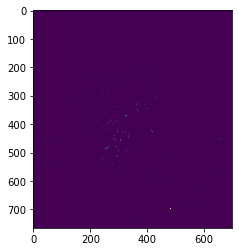

In [10]:
# Set the masked pixel to 0 so that difference between pixel values can be better seen
radar_img[radar_img==65535] = 0
plt.imshow(radar_img)
plt.show()

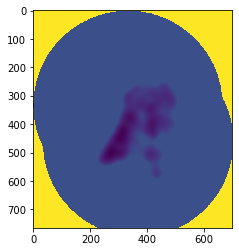

In [11]:
plt.imshow(img_mask)
plt.show()

Seems like the rough shape of the netherlands is displayed in this mask. Not sure how this image data should be interpreted.

Update: image2 displays correction fields, these are not needed for this project. image1 data is the only data that should be used in this project

## Convert data to numpy arrays

Convert h5 files to dataframe. The dataframe has three columns: timestamp, radar image data and the mask image data.

In [12]:
# Regex pattern to extract timestamp from filename
print(onlyfiles[0])
regex_p = re.compile('(\d{12})\.h5')
regex_p.findall(onlyfiles[0])[0]

RAD_NL25_RAC_RE_201901031355.h5


'201901031355'

In [39]:
folders = [f for f in os.listdir(path_ds) if os.path.isdir(os.path.join(path_ds, f))]
print(folders[2])
# Regex to extract time interval of folder
regex_p = re.compile('.+__(.+)_0001')
regex_p.findall(folders[0])[0]

RAD25_OPER_R___TARRRE__L2__20201216T080500_20201217T080000_0001


'20190316T080500_20190317T080000'

In [37]:
def load_h5(file_path):
    radar_img = None
    with h5py.File(file_path, 'r') as f:
        try:
            radar_img = np.array(f['image1']['image_data'])
        except:
            print("Error: could not read image1 data, file {}".format(file_path))
    return radar_img

In [7]:
def preprocess(in_dir, out_dir):
    '''
    Preprocess the h5 file into numpy arrays. 
    The timestamp, image1 and image2 data of each file is stored
    '''
    # Create directory if it does not exist
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    folders = [f for f in os.listdir(in_dir) if os.path.isdir(os.path.join(in_dir, f))]
    
    # Pattern for detecting timestamp in filename
    regex_file = re.compile('(\d{12})\.h5')
    # Pattern for detecting time interval in foldername
    regex_folder = re.compile('.+__(.+)_0001')
    
    
    for folder in tqdm(folders):
        radar_dir = in_dir + '/' + folder
        
        # check if regex pattern finds a timestamp
        try:
            interval = regex_folder.findall(folder)[0] 
        except:
            print('Error: could not find timestamp in folder {}'.format(folder))
            
        radar_dir_out = out_dir + '/' + interval + '/'    
        # Create directory if it does not exist
        if not os.path.exists(radar_dir_out):
            os.makedirs(radar_dir_out)        
        
        files = [f for f in os.listdir(radar_dir) if os.path.isfile(os.path.join(radar_dir, f))]
        
    
        for file in files:
            timestamp = int(regex_file.findall(file)[0])
            scan_fn = radar_dir_out + "{}.npy".format(timestamp)
            
            image1 = load_h5(radar_dir + '/' + file)
            
            radar_data = np.array([timestamp, image1])
            np.save(scan_fn, radar_data)    

In [8]:
in_dir = '/nobackup/users/schreurs/project_GAN/dataset'
out_dir = '/nobackup/users/schreurs/project_GAN/dataset_np'
preprocess(in_dir, out_dir)

  0%|          | 0/772 [00:00<?, ?it/s]/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  5%|▌         | 42/772 [02:49<34:15,  2.82s/it]  

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190727T080500_20190728T080000_0001/RAD_NL25_RAC_RE_201907271440.h5


  7%|▋         | 55/772 [03:27<35:55,  3.01s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190907T080500_20190908T080000_0001/RAD_NL25_RAC_RE_201909080450.h5


 12%|█▏        | 93/772 [05:34<30:09,  2.66s/it]  

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190807T080500_20190808T080000_0001/RAD_NL25_RAC_RE_201908072010.h5


 16%|█▌        | 120/772 [07:03<29:36,  2.72s/it]  

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20200113T080500_20200114T080000_0001/RAD_NL25_RAC_RE_202001140245.h5


 17%|█▋        | 132/772 [07:44<18:51,  1.77s/it]  

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20200106T080500_20200107T080000_0001/RAD_NL25_RAC_RE_202001061000.h5


 23%|██▎       | 179/772 [10:44<17:09,  1.74s/it]  

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190508T080500_20190509T080000_0001/RAD_NL25_RAC_RE_201905090650.h5


 34%|███▍      | 265/772 [16:11<42:06,  4.98s/it]  

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190817T080500_20190818T080000_0001/RAD_NL25_RAC_RE_201908171305.h5


 35%|███▌      | 271/772 [16:21<17:34,  2.10s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20191223T080500_20191224T080000_0001/RAD_NL25_RAC_RE_201912230900.h5


 40%|███▉      | 308/772 [19:03<1:03:00,  8.15s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20191130T080500_20191201T080000_0001/RAD_NL25_RAC_RE_201912010215.h5


 40%|████      | 312/772 [19:14<29:08,  3.80s/it]  

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190814T080500_20190815T080000_0001/RAD_NL25_RAC_RE_201908150250.h5


 50%|█████     | 387/772 [23:56<13:31,  2.11s/it]  

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20191208T080500_20191209T080000_0001/RAD_NL25_RAC_RE_201912081405.h5


 52%|█████▏    | 403/772 [25:10<25:13,  4.10s/it]  

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190414T080500_20190415T080000_0001/RAD_NL25_RAC_RE_201904141520.h5


 58%|█████▊    | 449/772 [27:53<13:20,  2.48s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190724T080500_20190725T080000_0001/RAD_NL25_RAC_RE_201907241320.h5


 61%|██████    | 470/772 [29:19<10:48,  2.15s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20191213T080500_20191214T080000_0001/RAD_NL25_RAC_RE_201912130840.h5


 64%|██████▍   | 496/772 [31:00<18:23,  4.00s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190725T080500_20190726T080000_0001/RAD_NL25_RAC_RE_201907260635.h5


 70%|███████   | 542/772 [34:14<32:35,  8.50s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20200109T080500_20200110T080000_0001/RAD_NL25_RAC_RE_202001091945.h5


 78%|███████▊  | 605/772 [38:16<10:47,  3.88s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20200128T080500_20200129T080000_0001/RAD_NL25_RAC_RE_202001282310.h5


 87%|████████▋ | 672/772 [42:43<08:25,  5.05s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20191203T080500_20191204T080000_0001/RAD_NL25_RAC_RE_201912031750.h5


 94%|█████████▍| 726/772 [46:32<04:53,  6.38s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20191025T080500_20191026T080000_0001/RAD_NL25_RAC_RE_201910260420.h5


 96%|█████████▋| 744/772 [47:35<00:57,  2.05s/it]

Error: could not read image1 data, file /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20200119T080500_20200120T080000_0001/RAD_NL25_RAC_RE_202001200000.h5


100%|██████████| 772/772 [49:33<00:00,  3.85s/it]


## Problem: three files have no image_data

Apparently there are a couple of timestamps that miss image1 data (i.e. no image_data dataset in the h5 file). 
Should look into whether these timestamps miss data or if the files got corrupted during downloading. With the code below I compare the content of h5 file of timestamp that was said to miss image_data with one that had this data

In [29]:
# https://stackoverflow.com/questions/44883175/how-to-list-all-datasets-in-h5py-file
# show all data in a hdf5 file
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print(sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print(sep + '\t', '-',key,':',obj.attrs[key])

def h5dump(path,group='/'):
    """
    print HDF5 file metadata

    group: you can give a specific group, defaults to the root group
    """
    with h5py.File(path,'r') as f:
         descend_obj(f[group])

In [31]:
path_error= '/nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190727T080500_20190728T080000_0001/RAD_NL25_RAC_RE_201907271440.h5'
h5dump(path_error)

	 - geographic : <HDF5 group "/geographic" (1 members)>
		 - map_projection : <HDF5 group "/geographic/map_projection" (0 members)>
	 - image1 : <HDF5 group "/image1" (2 members)>
		 - calibration : <HDF5 group "/image1/calibration" (0 members)>
		 - statistics : <HDF5 group "/image1/statistics" (0 members)>
	 - image2 : <HDF5 group "/image2" (3 members)>
		 - calibration : <HDF5 group "/image2/calibration" (0 members)>
		 - image_data : <HDF5 dataset "image_data": shape (765, 700), type "<u2">
		 - statistics : <HDF5 group "/image2/statistics" (0 members)>
	 - overview : <HDF5 group "/overview" (0 members)>
	 - radar1 : <HDF5 group "/radar1" (0 members)>
	 - radar2 : <HDF5 group "/radar2" (0 members)>
	 - radar3 : <HDF5 group "/radar3" (0 members)>
	 - radar4 : <HDF5 group "/radar4" (0 members)>
	 - radar5 : <HDF5 group "/radar5" (0 members)>
	 - radar6 : <HDF5 group "/radar6" (0 members)>


In [32]:
path_no_error= '/nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190727T080500_20190728T080000_0001/RAD_NL25_RAC_RE_201907271540.h5'
h5dump(path_no_error)

	 - geographic : <HDF5 group "/geographic" (1 members)>
		 - map_projection : <HDF5 group "/geographic/map_projection" (0 members)>
	 - image1 : <HDF5 group "/image1" (3 members)>
		 - calibration : <HDF5 group "/image1/calibration" (0 members)>
		 - image_data : <HDF5 dataset "image_data": shape (765, 700), type "<u2">
		 - statistics : <HDF5 group "/image1/statistics" (0 members)>
	 - image2 : <HDF5 group "/image2" (3 members)>
		 - calibration : <HDF5 group "/image2/calibration" (0 members)>
		 - image_data : <HDF5 dataset "image_data": shape (765, 700), type "<u2">
		 - statistics : <HDF5 group "/image2/statistics" (0 members)>
	 - overview : <HDF5 group "/overview" (0 members)>
	 - radar1 : <HDF5 group "/radar1" (0 members)>
	 - radar2 : <HDF5 group "/radar2" (0 members)>
	 - radar3 : <HDF5 group "/radar3" (0 members)>
	 - radar4 : <HDF5 group "/radar4" (0 members)>
	 - radar5 : <HDF5 group "/radar5" (0 members)>
	 - radar6 : <HDF5 group "/radar6" (0 members)>


## Pack data into sequences

Instead of storing 1 timestamp in 1 file, store a sequence of radarscans into 1 file. This will make loading the training data easier as the sequence of radarscans does not have to be made at runtime. These packages of sequences can later be linked with the target data.

First the radar scans are packed into sequences of 30 minutes (6 radarscans long). These can then be matched with the Aarts target data of 30 minutes ahead. This would mean that there are 288/6 = 48 sequences in a day(/folder)

In [7]:
np_dir = '/nobackup/users/schreurs/project_GAN/dataset_np/'
dir_30m = '/nobackup/users/schreurs/project_GAN/dataset_np_30m/'

In [154]:
def preprocess_into_sequences(in_dir, out_dir, n=6):
    '''
    Preprocess the numpy files into sequences. 
    n is the length of the input sequence, default is 6 images (with interval of 5 resulting in 30 minutes)
    '''
    # Create directory if it does not exist
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    folders = sorted([f for f in os.listdir(in_dir) if os.path.isdir(os.path.join(in_dir, f))])
    
    regex_file = re.compile('(\d{12})\.h5')
    # Each folder corresponds to a day
    for folder in tqdm(folders[:100]):
        day_dir = in_dir + '/' + folder + '/'
        print(day_dir)
        # A new file each 5 minutes: 288 files in a day
        files = sorted([f for f in os.listdir(day_dir) if os.path.isfile(os.path.join(day_dir, f))])
        
        if len(files) != 288:
            print('Day {} has {} radar scans instead of 288'.format(folder, len(files)))
        for i in range(0,len(files)-n, n+1):
            sequence_i = files[i:i+n]
            
            sequence = []
            date_prev = None

            sequence_name = files[i].replace('.npy', 'seq{}m'.format(5*n))
            for file in sequence_i:
                file_path = day_dir + file
                timestamp, image = np.load(file_path, allow_pickle=True)
                
                if date_prev:
                    # check if interval is 5 
                    date_current = datetime.datetime.strptime(str(a), '%Y%m%d%H%M')
                    interval = int((date_current-date_prev).seconds / 60) 
        
                    if interval != 5:
                        print(date_current, date_prev, interval)
                    date_prev = date_current
                sequence.append(image)
            sequence = np.array(sequence)
            #np.save(out_dir+sequence_name, sequence)

In [155]:
preprocess_into_sequences(np_dir, dir_30m)

  0%|          | 0/100 [00:00<?, ?it/s]

/nobackup/users/schreurs/project_GAN/dataset_np/201812170755_201812180800/
Day 201812170755_201812180800 has 259 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/201812180755_201812190800/
Day 201812180755_201812190800 has 547 radar scans instead of 288


  2%|▏         | 2/100 [00:06<05:19,  3.26s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/201812190755_201812200800/
Day 201812190755_201812200800 has 488 radar scans instead of 288


  3%|▎         | 3/100 [00:12<06:57,  4.30s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/201812200755_201812210800/
Day 201812200755_201812210800 has 285 radar scans instead of 288


  4%|▍         | 4/100 [00:15<06:15,  3.91s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/201812210755_201812220800/
Day 201812210755_201812220800 has 277 radar scans instead of 288


  5%|▌         | 5/100 [00:18<05:52,  3.71s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181221T075500_20181222T080000/
Day 20181221T075500_20181222T080000 has 277 radar scans instead of 288


  6%|▌         | 6/100 [00:22<05:38,  3.60s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181222T080500_20181223T080000/
Day 20181222T080500_20181223T080000 has 286 radar scans instead of 288


  7%|▋         | 7/100 [00:25<05:30,  3.55s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181223T080500_20181224T080000/
Day 20181223T080500_20181224T080000 has 287 radar scans instead of 288


  8%|▊         | 8/100 [00:29<05:24,  3.52s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181224T080500_20181225T080000/
Day 20181224T080500_20181225T080000 has 286 radar scans instead of 288


  9%|▉         | 9/100 [00:32<05:14,  3.46s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181225T080500_20181226T080000/
Day 20181225T080500_20181226T080000 has 283 radar scans instead of 288


 10%|█         | 10/100 [00:35<05:07,  3.42s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181226T080500_20181227T080000/
Day 20181226T080500_20181227T080000 has 285 radar scans instead of 288


 11%|█         | 11/100 [00:39<05:03,  3.41s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181227T080500_20181228T080000/
Day 20181227T080500_20181228T080000 has 280 radar scans instead of 288


 12%|█▏        | 12/100 [00:42<04:59,  3.40s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181228T080500_20181229T080000/
Day 20181228T080500_20181229T080000 has 287 radar scans instead of 288


 13%|█▎        | 13/100 [00:46<04:58,  3.44s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181229T080500_20181230T080000/
Day 20181229T080500_20181230T080000 has 283 radar scans instead of 288


 14%|█▍        | 14/100 [00:49<04:55,  3.44s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181230T080500_20181231T080000/
Day 20181230T080500_20181231T080000 has 285 radar scans instead of 288


 15%|█▌        | 15/100 [00:52<04:50,  3.42s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20181231T080500_20190101T080000/
Day 20181231T080500_20190101T080000 has 286 radar scans instead of 288


 16%|█▌        | 16/100 [00:56<04:48,  3.43s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190101T080500_20190102T080000/
Day 20190101T080500_20190102T080000 has 286 radar scans instead of 288


 17%|█▋        | 17/100 [00:59<04:43,  3.42s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190102T080500_20190103T080000/
Day 20190102T080500_20190103T080000 has 285 radar scans instead of 288


 18%|█▊        | 18/100 [01:03<04:38,  3.40s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190103T080500_20190104T080000/
Day 20190103T080500_20190104T080000 has 285 radar scans instead of 288


 19%|█▉        | 19/100 [01:06<04:29,  3.33s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190104T080500_20190105T080000/
Day 20190104T080500_20190105T080000 has 287 radar scans instead of 288


 20%|██        | 20/100 [01:09<04:30,  3.38s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190105T080500_20190106T080000/


 21%|██        | 21/100 [01:13<04:29,  3.41s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190106T080500_20190107T080000/


 22%|██▏       | 22/100 [01:16<04:25,  3.41s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190107T080500_20190108T080000/
Day 20190107T080500_20190108T080000 has 287 radar scans instead of 288


 23%|██▎       | 23/100 [01:20<04:22,  3.40s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190108T080500_20190109T080000/
Day 20190108T080500_20190109T080000 has 287 radar scans instead of 288


 24%|██▍       | 24/100 [01:23<04:18,  3.39s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190109T080500_20190110T080000/


 25%|██▌       | 25/100 [01:26<04:16,  3.43s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190110T080500_20190111T080000/
Day 20190110T080500_20190111T080000 has 286 radar scans instead of 288


 26%|██▌       | 26/100 [01:30<04:13,  3.42s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190111T080500_20190112T080000/
Day 20190111T080500_20190112T080000 has 283 radar scans instead of 288


 27%|██▋       | 27/100 [01:33<04:04,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190112T080500_20190113T080000/
Day 20190112T080500_20190113T080000 has 259 radar scans instead of 288


 28%|██▊       | 28/100 [01:36<03:57,  3.29s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190113T080500_20190114T080000/
Day 20190113T080500_20190114T080000 has 286 radar scans instead of 288


 29%|██▉       | 29/100 [01:40<03:56,  3.33s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190114T080500_20190115T080000/
Day 20190114T080500_20190115T080000 has 285 radar scans instead of 288


 30%|███       | 30/100 [01:43<03:49,  3.27s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190115T080500_20190116T080000/
Day 20190115T080500_20190116T080000 has 287 radar scans instead of 288


 31%|███       | 31/100 [01:46<03:49,  3.32s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190116T080500_20190117T080000/
Day 20190116T080500_20190117T080000 has 285 radar scans instead of 288


 32%|███▏      | 32/100 [01:50<03:47,  3.34s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190117T080500_20190118T080000/
Day 20190117T080500_20190118T080000 has 283 radar scans instead of 288


 33%|███▎      | 33/100 [01:53<03:45,  3.37s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190118T080500_20190119T080000/
Day 20190118T080500_20190119T080000 has 281 radar scans instead of 288


 34%|███▍      | 34/100 [01:56<03:37,  3.29s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190119T080500_20190120T080000/
Day 20190119T080500_20190120T080000 has 283 radar scans instead of 288


 35%|███▌      | 35/100 [01:59<03:35,  3.32s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190120T080500_20190121T080000/
Day 20190120T080500_20190121T080000 has 283 radar scans instead of 288


 36%|███▌      | 36/100 [02:03<03:34,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190121T080500_20190122T080000/
Day 20190121T080500_20190122T080000 has 284 radar scans instead of 288


 37%|███▋      | 37/100 [02:06<03:26,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190122T080500_20190123T080000/
Day 20190122T080500_20190123T080000 has 282 radar scans instead of 288


 38%|███▊      | 38/100 [02:09<03:26,  3.32s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190123T080500_20190124T080000/
Day 20190123T080500_20190124T080000 has 284 radar scans instead of 288


 39%|███▉      | 39/100 [02:13<03:18,  3.26s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190124T080500_20190125T080000/
Day 20190124T080500_20190125T080000 has 280 radar scans instead of 288


 40%|████      | 40/100 [02:16<03:16,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190125T080500_20190126T080000/
Day 20190125T080500_20190126T080000 has 281 radar scans instead of 288


 41%|████      | 41/100 [02:19<03:13,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190126T080500_20190127T080000/
Day 20190126T080500_20190127T080000 has 277 radar scans instead of 288


 42%|████▏     | 42/100 [02:22<03:10,  3.29s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190127T080500_20190128T080000/
Day 20190127T080500_20190128T080000 has 277 radar scans instead of 288


 43%|████▎     | 43/100 [02:26<03:06,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190128T080500_20190129T080000/
Day 20190128T080500_20190129T080000 has 274 radar scans instead of 288


 44%|████▍     | 44/100 [02:29<03:03,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190129T080500_20190130T080000/
Day 20190129T080500_20190130T080000 has 278 radar scans instead of 288


 45%|████▌     | 45/100 [02:32<03:00,  3.27s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190130T080500_20190131T080000/
Day 20190130T080500_20190131T080000 has 279 radar scans instead of 288


 46%|████▌     | 46/100 [02:36<02:57,  3.29s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190131T080500_20190201T080000/
Day 20190131T080500_20190201T080000 has 280 radar scans instead of 288


 47%|████▋     | 47/100 [02:39<02:55,  3.31s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190201T080500_20190202T080000/
Day 20190201T080500_20190202T080000 has 280 radar scans instead of 288


 48%|████▊     | 48/100 [02:42<02:55,  3.37s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190202T080500_20190203T080000/
Day 20190202T080500_20190203T080000 has 282 radar scans instead of 288


 49%|████▉     | 49/100 [02:46<02:52,  3.39s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190203T080500_20190204T080000/
Day 20190203T080500_20190204T080000 has 280 radar scans instead of 288


 50%|█████     | 50/100 [02:49<02:47,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190204T080500_20190205T080000/
Day 20190204T080500_20190205T080000 has 280 radar scans instead of 288


 51%|█████     | 51/100 [02:53<02:44,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190205T080500_20190206T080000/
Day 20190205T080500_20190206T080000 has 281 radar scans instead of 288


 52%|█████▏    | 52/100 [02:56<02:40,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190206T080500_20190207T080000/
Day 20190206T080500_20190207T080000 has 279 radar scans instead of 288


 53%|█████▎    | 53/100 [02:59<02:35,  3.31s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190207T080500_20190208T080000/
Day 20190207T080500_20190208T080000 has 283 radar scans instead of 288


 54%|█████▍    | 54/100 [03:02<02:33,  3.34s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190208T080500_20190209T080000/
Day 20190208T080500_20190209T080000 has 247 radar scans instead of 288


 55%|█████▌    | 55/100 [03:05<02:25,  3.23s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190209T080500_20190210T080000/
Day 20190209T080500_20190210T080000 has 281 radar scans instead of 288


 56%|█████▌    | 56/100 [03:09<02:22,  3.24s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190210T080500_20190211T080000/
Day 20190210T080500_20190211T080000 has 279 radar scans instead of 288


 57%|█████▋    | 57/100 [03:12<02:21,  3.28s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190211T080500_20190212T080000/
Day 20190211T080500_20190212T080000 has 283 radar scans instead of 288


 58%|█████▊    | 58/100 [03:16<02:20,  3.34s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190212T080500_20190213T080000/
Day 20190212T080500_20190213T080000 has 284 radar scans instead of 288


 59%|█████▉    | 59/100 [03:19<02:17,  3.36s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190213T080500_20190214T080000/
Day 20190213T080500_20190214T080000 has 281 radar scans instead of 288


 60%|██████    | 60/100 [03:22<02:14,  3.35s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190214T080500_20190215T080000/
Day 20190214T080500_20190215T080000 has 282 radar scans instead of 288


 61%|██████    | 61/100 [03:26<02:12,  3.39s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190215T080500_20190216T080000/
Day 20190215T080500_20190216T080000 has 286 radar scans instead of 288


 62%|██████▏   | 62/100 [03:29<02:08,  3.38s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190216T080500_20190217T080000/
Day 20190216T080500_20190217T080000 has 284 radar scans instead of 288


 63%|██████▎   | 63/100 [03:32<02:04,  3.36s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190217T080500_20190218T080000/
Day 20190217T080500_20190218T080000 has 284 radar scans instead of 288


 64%|██████▍   | 64/100 [03:35<01:52,  3.12s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190218T080500_20190219T080000/
Day 20190218T080500_20190219T080000 has 283 radar scans instead of 288


 66%|██████▌   | 66/100 [03:38<01:11,  2.11s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190219T080500_20190220T080000/
Day 20190219T080500_20190220T080000 has 287 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190220T080500_20190221T080000/


 67%|██████▋   | 67/100 [03:38<00:49,  1.51s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190221T080500_20190222T080000/
Day 20190221T080500_20190222T080000 has 287 radar scans instead of 288


 68%|██████▊   | 68/100 [03:41<01:04,  2.00s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190222T080500_20190223T080000/
Day 20190222T080500_20190223T080000 has 284 radar scans instead of 288


 69%|██████▉   | 69/100 [03:44<01:14,  2.40s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190223T080500_20190224T080000/


 70%|███████   | 70/100 [03:48<01:22,  2.74s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190224T080500_20190225T080000/
Day 20190224T080500_20190225T080000 has 285 radar scans instead of 288


100%|██████████| 100/100 [03:51<00:00,  2.32s/it]

/nobackup/users/schreurs/project_GAN/dataset_np/20190225T080500_20190226T080000/
Day 20190225T080500_20190226T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190226T080500_20190227T080000/
Day 20190226T080500_20190227T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190227T080500_20190228T080000/
Day 20190227T080500_20190228T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190228T080500_20190301T080000/
Day 20190228T080500_20190301T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190301T080500_20190302T080000/
Day 20190301T080500_20190302T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190302T080500_20190303T080000/
Day 20190302T080500_20190303T080000 has 1 radar scans instead of 288
/nobackup/users/schreurs/project_GAN/dataset_np/20190303T080500_20190304T080000/
Day 20190303T080500

In [39]:
ls /nobackup/users/schreurs/project_GAN/dataset_np/201812170755_201812180800 |head

201812171030.npy
201812171035.npy
201812171040.npy
201812171045.npy
201812171050.npy
201812171055.npy
201812171100.npy
201812171105.npy
201812171110.npy
201812171115.npy


Some days seem to lack a lot of data. Maybe something went wrong during downloading these dates or during unpacking

In [26]:
ls /nobackup/users/schreurs/project_GAN/dataset_np/20190309T080500_20190310T080000/

201903100800.npy


In [11]:
ls /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001

RAD_NL25_RAC_RE_201903100800.h5


In [19]:
ls /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001.tar

/nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001.tar


As you can see there is only 1 radar scan of the date 2019-03-10. Below I unpack the tar file of that date again to test if something went wrong during the unpacking

In [20]:
# Testing path
tar_path = '/nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001.tar'
print("tar path: ", tar_path)
unpack_folder = tar_path.replace('.tar','')
print("unpack in folder: ", unpack_folder)

tar path:  /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001.tar
unpack in folder:  /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001


In [23]:
with tarfile.open(tar_path) as tar:
    tar.extractall(unpack_folder) 

In [24]:
ls /nobackup/users/schreurs/project_GAN/dataset/RAD25_OPER_R___TARRRE__L2__20190309T080500_20190310T080000_0001

RAD_NL25_RAC_RE_201903100800.h5


Unpacking the tar files does not seem te be the problem.

When mannually download the tar file of 20190309T080500_20190310T080000 the radar data looks complete. During downloading the files probably got corrupted. 

Noticed a difference in dataset names: nl_rdr_data_rtcor_5m vs nl_rdr_data_recor_5m.
Currently using the recor dataset, the rtcor might have complete data unlike the rtcor. 

(Waiting on API request for bulk dowload rtcor instead of recor dataset)

# Aart Radar Dataset

In [2]:
path_aart = '/nobackup/users/schreurs/project_GAN/dataset_aart'

folders = sorted([f for f in os.listdir(path_aart) if os.path.isdir(os.path.join(path_aart, f))])

In [3]:
ls /nobackup/users/schreurs/project_GAN/dataset_aart/2008

2008/  2008.zip


In [38]:
# Testing path
zip_path = path_aart + '/' + folders[0] + '/' + folders[0] + '.zip'
print("zip path: ", zip_path)
unpack_folder = path_aart + '/' + folders[0]
print("unpack in folder: ", unpack_folder)

zip path:  /nobackup/users/schreurs/project_GAN/dataset_aart/2008/2008.zip
unpack in folder:  /nobackup/users/schreurs/project_GAN/dataset_aart/2008


In [41]:
for folder in tqdm(folders):
    zip_path = path_aart + '/' + folder + '/' + folder + '.zip'
    unpack_folder = path_aart + '/' + folder
    
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        zip_file.extractall(unpack_folder)

100%|██████████| 13/13 [16:35<00:00, 76.61s/it]


In [45]:
ls /nobackup/users/schreurs/project_GAN/dataset_aart/2008/2008/

01/  02/  03/  04/  05/  06/  07/  08/  09/  10/  11/  12/


In [4]:
ls /nobackup/users/schreurs/project_GAN/dataset_aart/2008/2008/01 | head

RAD_NL25_RAC_MFBS_EM_5min_200801010000.nc
RAD_NL25_RAC_MFBS_EM_5min_200801010005.nc
RAD_NL25_RAC_MFBS_EM_5min_200801010010.nc
RAD_NL25_RAC_MFBS_EM_5min_200801010015.nc
RAD_NL25_RAC_MFBS_EM_5min_200801010020.nc
RAD_NL25_RAC_MFBS_EM_5min_200801010025.nc
RAD_NL25_RAC_MFBS_EM_5min_200801010030.nc
RAD_NL25_RAC_MFBS_EM_5min_200801010035.nc
RAD_NL25_RAC_MFBS_EM_5min_200801010040.nc
RAD_NL25_RAC_MFBS_EM_5min_200801010045.nc
ls: write error: Broken pipe


## Open NC file

In [6]:
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap

In [87]:
path_nc = path_aart + '/2018/2018/01/RAD_NL25_RAC_MFBS_EM_5min_201801010000.nc' 
ds = Dataset(path_nc, mode='r')
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.5
    history: Metadata adjusted by ADAGUC from KNMIHDF5 to NetCDF-CF
    dimensions(sizes): y(765), x(700), time(1)
    variables(dimensions): float64 y(y), float64 x(x), float64 time(time), |S1 geographic(), |S1 image1_calibration(), uint16 image1_image_data(time,y,x), |S1 overview(), |S1 radar1(), |S1 radar2(), |S1 radar3(), |S1 product(), |S1 iso_dataset(), |S1 projection()
    groups: 

In [88]:
ds.variables

{'y': <class 'netCDF4._netCDF4.Variable'>
 float64 y(y)
     standard_name: projection_y_coordinate
     long_name: y coordinate of projection
     units: km
 unlimited dimensions: 
 current shape = (765,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'x': <class 'netCDF4._netCDF4.Variable'>
 float64 x(x)
     standard_name: projection_x_coordinate
     long_name: x coordinate of projection
     units: km
 unlimited dimensions: 
 current shape = (700,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     units: seconds since 2000-01-01 00:00:00
     standard_name: time
     calendar: standard
     long_name: time
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'geographic': <class 'netCDF4._netCDF4.Variable'>
 |S1 geographic()
     geo_number_rows: 765
     geo_number_columns: 700
     geo_pixel_size_x: 1.0
     geo_pixel_size_y

Plot the map

In [89]:
iso_dict = ds['iso_dataset'].__dict__
min_x = float(iso_dict['min_x'].replace('f', ''))
min_y = float(iso_dict['min_y'].replace('f', ''))
max_x = float(iso_dict['max_x'].replace('f', ''))
max_y = float(iso_dict['max_y'].replace('f', ''))
print(min_x,min_y,max_x,max_y)

0.0 49.362 10.856 55.389


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """Entry point for launching an IPython kernel.


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':


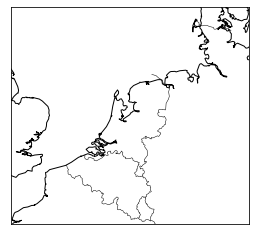

In [109]:
mp = Basemap(projection='merc',
             llcrnrlon=min_x,   # lower longitude
             llcrnrlat=min_y,    # lower latitude
             urcrnrlon=max_x,   # uppper longitude
             urcrnrlat=max_y,   # uppper latitude
            resolution = 'i')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [91]:
x = ds['x'][:]
y = ds['y'][:]
print(x.shape)
print(y.shape)

(700,)
(765,)


In [92]:
x[:5]

masked_array(data=[0.5, 1.5, 2.5, 3.5, 4.5],
             mask=False,
       fill_value=1e+20)

In [93]:
y[:5]

masked_array(data=[-3650.5, -3651.5, -3652.5, -3653.5, -3654.5],
             mask=False,
       fill_value=1e+20)

In [179]:
rain = ds['image1_image_data'][:]
rain.shape

(1, 765, 700)

In [180]:
np.unique(rain)

masked_array(data=[0.0, 0.009999999776482582, 0.019999999552965164,
                   0.029999999329447746, 0.03999999910593033,
                   0.04999999701976776, 0.05999999865889549,
                   0.07000000029802322, 0.07999999821186066,
                   0.08999999612569809, 0.09999999403953552,
                   0.10999999940395355, 0.11999999731779099,
                   0.12999999523162842, 0.14000000059604645,
                   0.14999999105930328, 0.1599999964237213,
                   0.17000000178813934, 0.17999999225139618,
                   0.1899999976158142, 0.19999998807907104,
                   0.20999999344348907, 0.2199999988079071,
                   0.22999998927116394, 0.23999999463558197, 0.25,
                   0.25999999046325684, 0.26999998092651367,
                   0.2800000011920929, 0.28999999165534973,
                   0.29999998211860657, 0.3100000023841858,
                   0.3199999928474426, 0.32999998331069946,
                

The precipitation array is a masked array. The Extended Mask (EM) dataset is used, so the Netherlands with an extended border over sea, belgium and germany is not masked

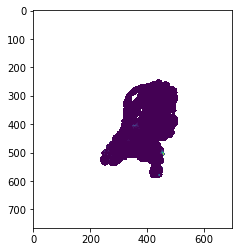

In [181]:
plt.imshow(np.squeeze(rain))

Now plot the precipitation data on top of a map

In [162]:
import pyproj 
X, Y = np.meshgrid(x, y)
# original projection
p = pyproj.Proj("+proj=stere +lat_0=90 +lat_ts=60 +lon_0=0 +k=90 +x_0=0 +y_0=0 +a=6378.137000 +b=6356.752000")# +units=m +no_defs")
lon, lat = p(X*1000, Y*1000, inverse=True)

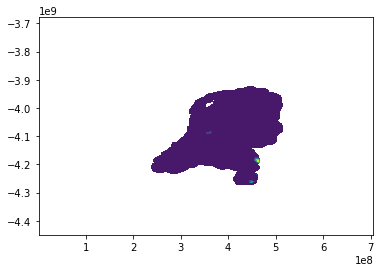

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'latlon'
  app.launch_new_instance()


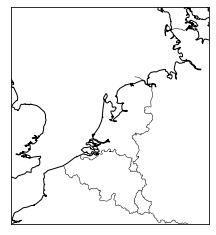

In [189]:

mp = Basemap(projection='stere',
             lat_0=90,
             lon_0=0, 
             lat_ts=60,   
             llcrnrlon=min_x,   # lower longitude
             llcrnrlat=min_y,    # lower latitude
             urcrnrlon=max_x,   # uppper longitude
             urcrnrlat=max_y,   # uppper latitude
             resolution='i'
            )
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

xx, yy = mp(lon, lat)
plt.contourf(xx, yy, np.squeeze(rain), latlon=True)
plt.show()

In [ ]:

mp = Basemap(projection='stere',
             lat_0=90,
             lon_0=0, 
             lat_ts=60,   
             llcrnrlon=-90,   # lower longitude
             llcrnrlat=min_y,    # lower latitude
             urcrnrlon=90,   # uppper longitude
             urcrnrlat=max_y,   # uppper latitude
             resolution='c'
            )
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

xx, yy = mp(lon, lat)
plt.contourf(xx, yy, np.squeeze(rain), latlon=True)
plt.show()